# LSH Demo

This notebook contains a demo implementation of Locality Sensitive Hashing for Euclidean approximate nearest neighbors. This is a toy implementation -- in practice, you should use one of the highly-tuned ANN libraries, such as `faiss` or `annoy`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,10)
%config InlineBackend.figure_format = 'retina'

These implementations of LSH are the same as given in lecture, except these return the *index* of the closest neighbor instead of the point itself. This will be useful later on in our experiments.

In [2]:
def gaussian_projection_matrix(k, d):
    X = np.random.normal(size=(k, d))
    Y = X / np.linalg.norm(X, axis=1)[:,None]
    return Y


def brute_force_nn(data, p):
    data = np.asarray(data)
    distances = np.linalg.norm(data - p, axis=1)
    ix = np.argmin(distances)
    return ix, distances[ix]


class NNProjectionGrid:
    """This is a toy implementation!"""
    
    def __init__(self, projection_matrix, width):
        self.width = width
        self.projection_matrix = projection_matrix
        self.cells = {}
        self.n = 0
        
    def cell_id(self, p):
        projection = self.projection_matrix @ p
        cell_id = np.floor(projection / self.width).astype(int)
        return tuple(cell_id)
    
    def insert(self, p):
        """Insert p into the grid."""
        cell_id = self.cell_id(p)
        i = self.n
        self.n += 1
        if cell_id not in self.cells:
            self.cells[cell_id] = []
        self.cells[cell_id].append((i, p))
        
    def points_in_cell(self, p):
        cell_id = self.cell_id(p)
        if cell_id not in self.cells:
            return [], []
        points_in_cell = self.cells[cell_id]
        # turn into an array
        indices = [x[0] for x in points_in_cell]
        points = [x[1] for x in points_in_cell]
        return np.array(indices), np.vstack(points)
    

class LocalitySensitiveHashing:
    
    def __init__(self, l, k, d, w):
        self.randomized_grids = []
        for i in range(l):
            U = gaussian_projection_matrix(k, d)
            self.randomized_grids.append(NNProjectionGrid(U, w))
            
    def insert(self, p):
        for randomized_grid in self.randomized_grids:
            randomized_grid.insert(p)
            
    def query_close(self, p):
        indices = []
        points = []
        for randomized_grid in self.randomized_grids:
            points_in_cell = randomized_grid.points_in_cell(p) 
            indices.extend(points_in_cell[0])
            points.extend(points_in_cell[1])
        return np.array(indices), np.vstack(points)
    
    def query_nn(self, point):
        indices, points = self.query_close(point)
        pool = np.vstack([r for r in points])
        if len(pool) == 0:
            raise ValueError('No points nearby. Increase l or w, or decrease k?')
        pool_ix, distance = brute_force_nn(pool, point)
        return indices[pool_ix], distance

## UTKFace Images Dataset

Let's test LSH on a dataset of images. We'll be using the UTKFace image data set. The next cells download this data.

In [3]:
%%bash
if [[ ! -f utkcropped.npz ]]; then
    wget https://github.com/eldridgejm/datasets/raw/master/utkface/utkcropped.npz
fi

In [4]:
%%bash
if [[ ! -f utkcropped-hog.npz ]]; then
    wget https://github.com/eldridgejm/datasets/raw/master/utkface/utkcropped-hog.npz
fi

We have download two files. The first is a collection of face images represented as numpy arrays.

In [5]:
faces = np.load('utkcropped.npz')['faces']

These images are 200 x 200 pixels, and are represented as 40000-dimensional vectors. We can visualize them using the function below:

In [6]:
def plot_image(im, ax=None):
    if ax is None:
        ax = plt
    n = im.shape[0]
    m = np.sqrt(n).astype(int)
    ax.imshow(im.reshape(m, -1), cmap='gray')

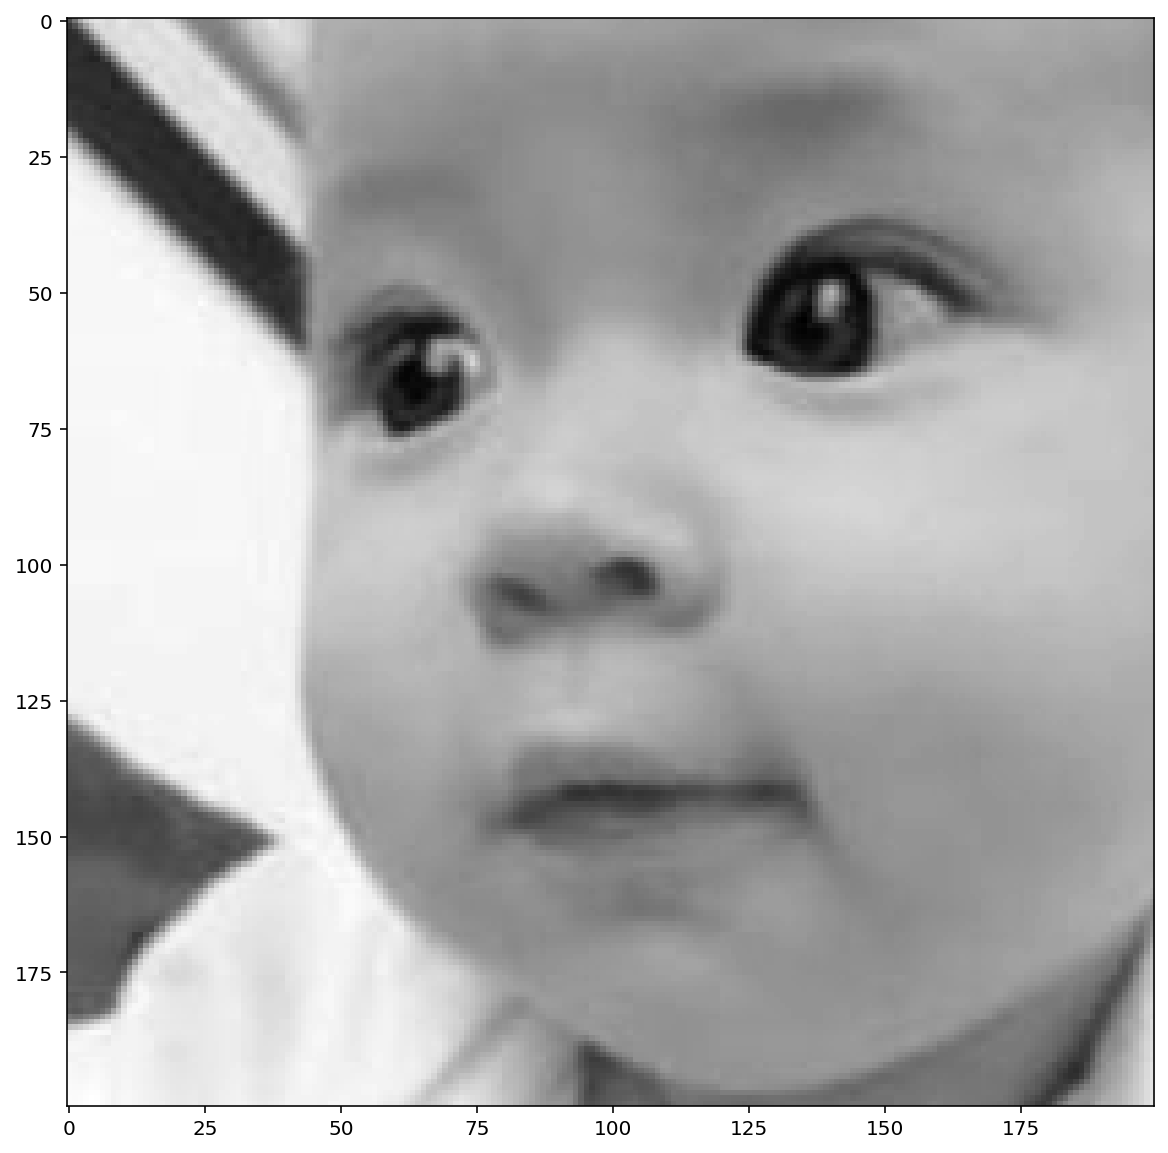

In [7]:
plot_image(faces[99])

For learning purposes, it is typically better to extract *features* from the image. One of the classical ways of doing this is with Hitograms of Oriented Gradients (HOG) features. The second file contains these features for each image:

In [8]:
features = np.load('utkcropped-hog.npz')['features']
features.shape

(9780, 2916)

In this dataset, each image is represented by a 2916-dimensional vector of features. However this feature vector is no longer meaningful when viewed as an image.

We will split the dataset into a "training" and "testing" set (although there isn't really any training going on). We can think of the training set as being the set of images we have stored in our database, and the test set consists of new images. We want to find the closest image in the database to our test image.

Note that this dataset was collected from the internet via an automated process, so there are some duplicates between the train set and the test set.

In [9]:
train_images = faces[:5000]
train_features = features[:5000]
test_images = faces[5000:]
test_features = features[5000:]

First, we create an LSH instance. The parameters were chosen by hand through simple trial-and-error.

In [10]:
np.random.seed(42)
lsh = LocalitySensitiveHashing(l=4, k=20, d=2916, w=800)
for vector in train_features:
    lsh.insert(vector)

In [12]:
def find_similar(ix):
    fig, axs = plt.subplots(nrows=1, ncols=2)
    nn_ix, _ = lsh.query_nn(test_features[ix])
    plot_image(test_images[ix], ax=axs[0])
    plt.figure()
    plot_image(train_images[nn_ix], ax=axs[1])
    axs[0].set_title('Test Image')
    axs[1].set_title('Closest Train Image')

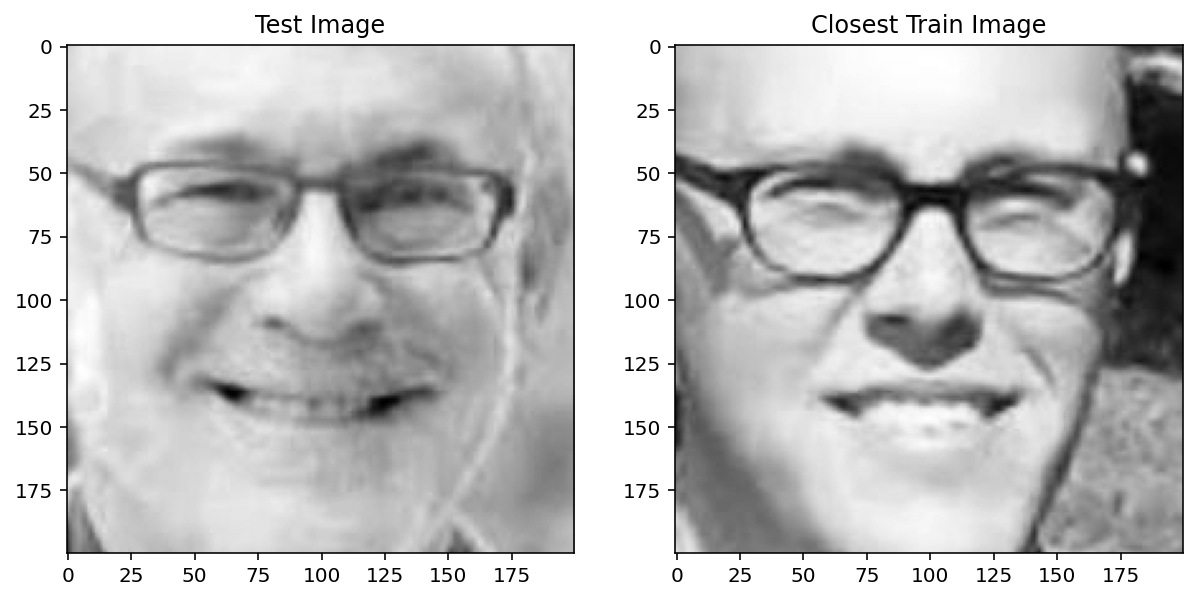

<Figure size 720x720 with 0 Axes>

In [13]:
find_similar(50)

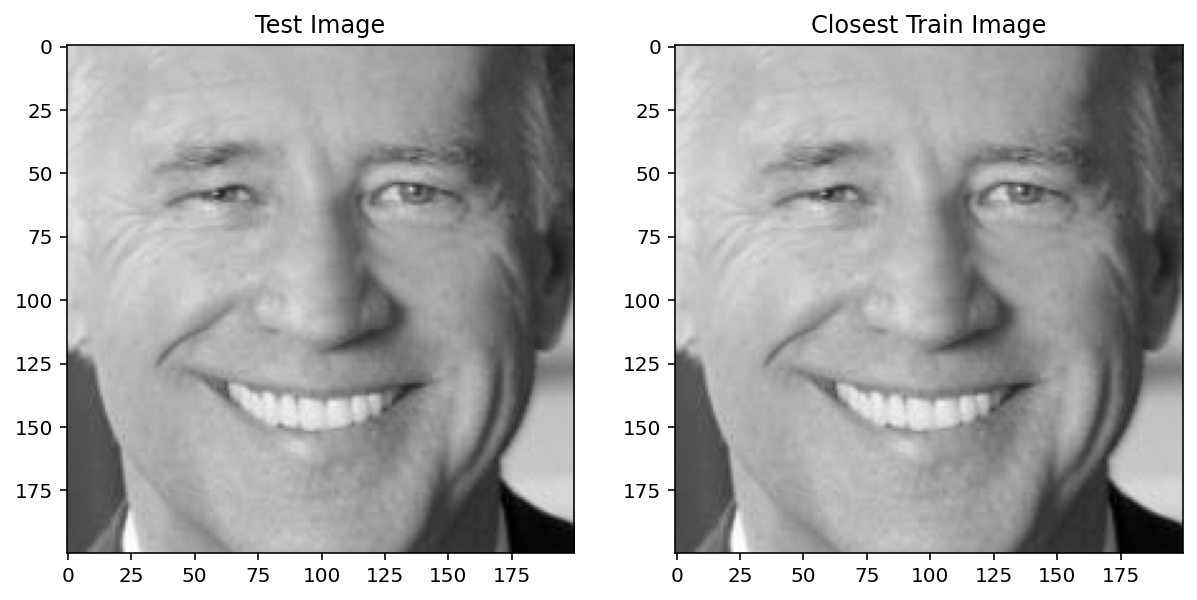

<Figure size 720x720 with 0 Axes>

In [14]:
find_similar(107)

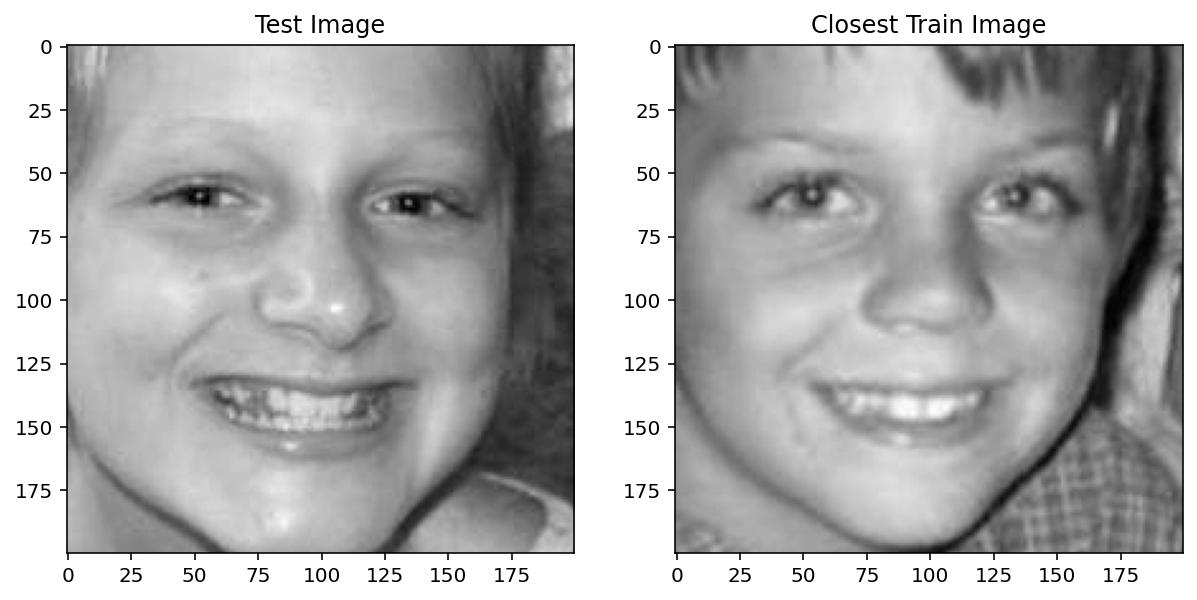

<Figure size 720x720 with 0 Axes>

In [15]:
find_similar(108)

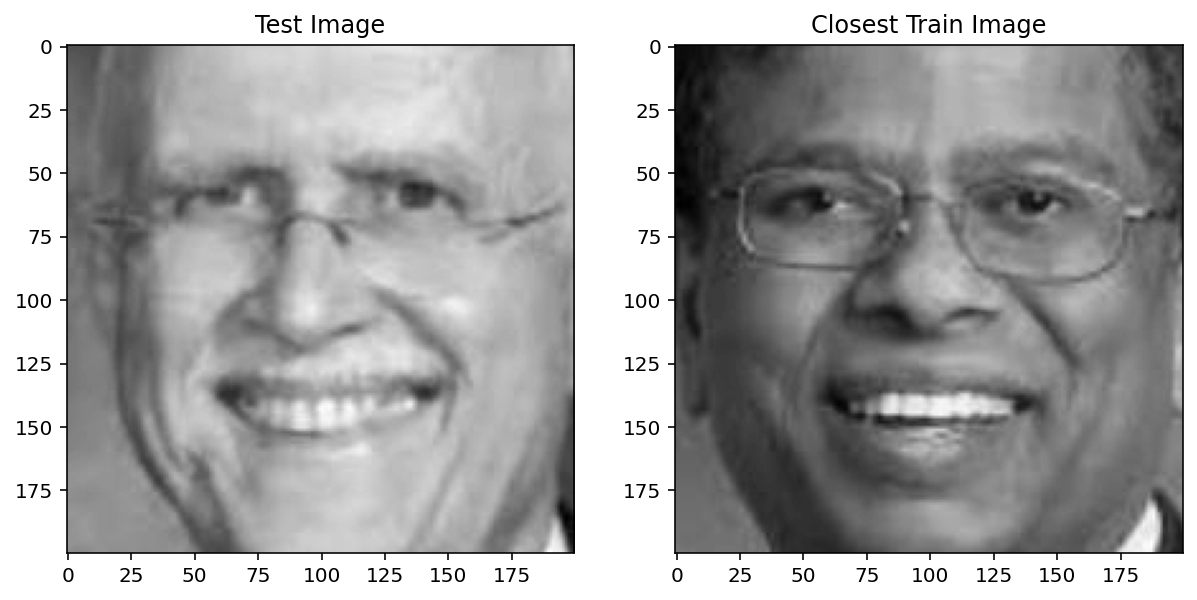

<Figure size 720x720 with 0 Axes>

In [16]:
find_similar(141)

## Performance Analysis

With $l = 4$, $k=20$, and $w = 800$ we seem to get good results with LSH. It's also quite fast (on the order of half a millisecond per query):

In [17]:
%%timeit
lsh.query_nn(test_features[0])

635 µs ± 80 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Compare this to brute force:

In [18]:
%%timeit
brute_force_nn(train_features, test_features[0])

60 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can also compare this to a k-d tree:

In [19]:
from dataclasses import dataclass
from typing import Union

@dataclass(init=True)
class KDInternalNode:
    """An internal node in a k-d tree."""
    
    # the left and right children, which are either KDInternalNodes or
    # leaf nodes (ndarrays)
    left: Union['KDInternalNode', np.ndarray]
    right: Union['KDInternalNode', np.ndarray]
        
    # the question's threshold and the dimension it refers to
    # Given an array representing a point, this asks:
    # is point[dimension] >= threshold?
    threshold: float
    dimension: int
        
    def __repr__(self):
        return f'KDInternalNode(dimension={self.dimension}, threshold={self.threshold})'
    
def build_kd_tree(data, m=5):
    """Construct a k-d tree from data.
    
    Parameters
    ----------
    data : ndarray
        An n x d array of n points in d dimensional space.
    m : int
        The max leaf node size. Default: 5
        
    Returns
    -------
    KDInternalNode or ndarray
        The root node of the k-d tree. If the number of the points in
        the tree is <5, returns the input ndarray.
    """
    if len(data) <= m:
        return data.copy()
    
    # find the dimension with greatest spread
    spread = data.max(axis=0) - data.min(axis=0)
    splitting_dimension = np.argmax(spread)
    
    # partition the data in-place around the median
    sort_ix = np.argpartition(data[:, splitting_dimension], len(data) // 2)
    data[:] = data[sort_ix]
    threshold = data[len(data) // 2, splitting_dimension]
    
    left_data, right_data = np.split(data, [len(data) // 2])
    
    left = build_kd_tree(left_data, m=m)
    right = build_kd_tree(right_data, m=m)
    
    return KDInternalNode(left=left, right=right, threshold=threshold, dimension=splitting_dimension)

def nn_query(node, p, alpha=1):
    """Returns closest point to p in subtree, along with its distance to p.
    
    Parameters
    ----------
    node : KDInternalNode
        The node whose subtree will be searched.
    p : ndarray
        A d-array representing the query point.
    alpha : float
        The approximation parameter. If alpha = 1, exact NN is found. The larger
        alpha is, the more approximate the answer. Default: 1.
    
    Returns
    -------
    ndarray
        The nearest neighbor of p.
    float
        The distance to the nearest neighbor.
    """
    if alpha < 1:
        raise ValueError('alpha must be >= 1')
        
    if isinstance(node, np.ndarray):
        return brute_force_nn_search(node, p)
    else:
        # print('\t' * tabs, f'is dimension {node.dimension} >= {node.threshold}?')
        # find the most likely branch
        if p[node.dimension] >= node.threshold:
            most_likely_branch, other_branch = node.right, node.left
        else:
            most_likely_branch, other_branch = node.left, node.right

        # compute distance to boundary
        distance_to_boundary = abs(p[node.dimension] - node.threshold)

        # find nn within most likely branch
        nn, nn_distance = nn_query(most_likely_branch, p, alpha=alpha)
        
        # check the other branch, but only if necessary
        if distance_to_boundary < nn_distance / alpha:
            nn_other, nn_other_distance = nn_query(other_branch, p, alpha=alpha)
            if nn_other_distance < nn_distance:
                nn = nn_other
                nn_distance = nn_other_distance

        return nn, nn_distance
    
def brute_force_nn_search(data, p):
    """Perform a brute force NN search.
    
    Parameters
    ----------
    data : ndarray
        An n x d array of n points in d dimensions.
    p : ndarray
        A d-array representing a query point.
        
    Returns
    -------
    ndarray
        The nearest neighbor of p.
    float
        The distance to the nearest neighbor.
        
    """
    distances = np.sqrt(np.sum((data - p)**2, axis=1))
    ix_of_nn = np.argmin(distances)
    nn = data[ix_of_nn]
    nn_distance = distances[ix_of_nn]
    return (nn, nn_distance)

In [20]:
root = build_kd_tree(train_features)

In [21]:
%%timeit
nn_query(root, test_features[0])

57.9 ms ± 4.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Of course, the k-d tree is doing an exact search. Let's try an approximate search.

In [22]:
%%timeit
nn_query(root, test_features[0], alpha=100)

1.65 ms ± 23.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Unfortunately, to get comparable times we have to crank the $\alpha$ parameter up to 100. Remember: this will allow the approximate NN to be 100 times as far as the exact NN! This is essentially a product of the fact that the k-d tree uses rectangular regions in a high-dimensional space.

Note that any comprehensize analysis of the efficiency of these approaches would also take into account their accuracy. That is, we can make any ANN algorithm run really fast if we don't care about the quality of the results. Qualitatively, LSH's results seem good for the settings listed above. However, we could measure the *recall* of each method by asking for the 50 nearest neighbors and comparing them to the 50 exact NNs as found by brute force.